In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from multiprocessing import Pool
from tqdm import tqdm
import pickle
from datetime import datetime
from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

Loading in all data for inspection:
0. data volume
1. field consistancy
2. missing values anywhere at all
3. data types
4. basic visualisation for relevant cols
5. etc

In [3]:
data_path = '/Users/ruoyangzhang/Documents/PythonWorkingDirectory/Eleven_super_case_customer_insights_Data/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [13]:
test = onlyfiles[8][8:14]

In [15]:
test[:4] + '-' + test[-2:]

'2017-10'

In [27]:
for file in onlyfiles:
    if file[:3] == 'LOG':
        print('the inspected log file is: ' + file)
    else:
        print('the inspected non log file is :' + file)
    print('it has: ', len(pd.read_csv('data/' + file, sep = ';', error_bad_lines = False)), 'lines')

the inspected non log file is :TABLE_CONVERSION.csv
it has:  580404 lines
the inspected non log file is :.DS_Store
it has:  0 lines
the inspected non log file is :CLIENTS.csv
it has:  3125800 lines
the inspected log file is: LOG_WEB_201710.csv
it has:  3301363 lines
the inspected log file is: LOG_WEB_201711.csv
it has:  5055599 lines
the inspected non log file is :CMD.csv
it has:  7323227 lines
the inspected log file is: LOG_WEB_201712.csv
it has:  4535451 lines
the inspected log file is: LOG_WEB_201708.csv
it has:  2189118 lines
the inspected log file is: LOG_WEB_201709.csv
it has:  2874217 lines
the inspected log file is: LOG_WEB_201801.csv


/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


it has:  8450825 lines
the inspected log file is: LOG_WEB_201802.csv
it has:  6063362 lines
the inspected log file is: LOG_WEB_201803.csv
it has:  2739719 lines


these files are rather large containing many lines, we should use a subset to test the robustness of the classification

In [194]:
data_201708 = pd.read_csv(data_path+'LOG_WEB_201708.csv', sep=';')

In [35]:
colns = sorted([col for col in list(data_201708.columns) if col[:3] != 'Unn'])

In [37]:
for file in onlyfiles:
    if file[:3] == 'LOG':
        colns_check = sorted([col for col in list(pd.read_csv('data/' + file, sep = ';').columns) if col[:3] != 'Unn'])
        print('the columns match the example columns: ', colns_check == colns)
        if colns_check != colns:
            print('the file with unmatched cols is: ', file)

the columns match the example columns:  True
the columns match the example columns:  True
the columns match the example columns:  True
the columns match the example columns:  True
the columns match the example columns:  True


/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


the columns match the example columns:  True
the columns match the example columns:  True
the columns match the example columns:  True


So the 201709 file is not matched, let's take a look at what's going on

In [3]:
data_201709 = pd.read_csv(data_path+'LOG_WEB_201709.csv', sep=';')~

In [4]:
data_201709.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'VISITOR_ID', 'CONNECTED_SESSION',
       'ID_SESSION', 'SESSION_START_DATE', 'EVENT_DATE', 'PAGES',
       'GLOBAL_SOURCES', 'DEVICE_TYPE', 'DEVICE_MODEL', 'LOADINGS'],
      dtype='object')

In [54]:
set(data_201709.GLOBAL_SOURCES)

{'Accès Direct',
 'Affiliation et partenaires',
 'Email marketing',
 'Liens Sponsorisés',
 'Moteurs',
 'Notoriété',
 'Publicité',
 'Sites affluents',
 'Sources naturelles personnalisées',
 'Webmails'}

Let's take a look at the non log files

In [5]:
conver = pd.read_csv(data_path+'TABLE_CONVERSION_new.csv', sep = ';')

In [5]:
conver.head()

,Unnamed: 0,VISITOR_ID,CLIENT_NUMBER
0,0,153926,2117916268519517296
1,1,153987,-3983308646720649306
2,2,153992,-2525192206264180159
3,3,153996,1543724696132514059
4,4,154002,-3753347333864614269


In [6]:
clients = pd.read_csv(data_path+'CLIENTS_new.csv', sep = ';')

In [134]:
clients.head()

,Unnamed: 0,CLIENT_NUMBER,CREATION_DATE,GENDER,BIRTH_YEAR,ZIPCODE
0,0,-1182315409949716431,2002-12-05,Mme,1955.0,68440
1,1,7142641182482142162,2002-12-05,Mme,NaN,24100
2,2,-4786858050561650068,2002-12-05,Mme,1945.0,39240
3,3,-8463163259230597037,2002-12-05,Mme,NaN,42290
4,4,-8047395753631590665,2003-10-06,Mme,1934.0,13006


In [7]:
CMD = pd.read_csv(data_path+'CMD_new.csv', sep = ';')

In [136]:
CMD.head()

,Unnamed: 0,CLIENT_NUMBER,ORDER_NUMBER,ORDER_DATE,ORDER_CHANNEL,PRE_TAX_AMOUNT,CVIC
0,0,7178742953965764755,2302390,2010-01-05,Telephone,84.28,True
1,1,-2373390172893352743,2302392,2010-01-17,Telephone,97.85,True
2,2,-240944575938990062,2302393,2010-01-05,Telephone,58.45,True
3,3,1720395480962300217,2302394,2010-01-05,Telephone,31.19,True
4,4,7161131950067982732,2302396,2010-01-14,Telephone,37.45,True


In [51]:
set(CMD.ORDER_CHANNEL)

{'Courier', 'Internet', 'Magasin', 'Non Renseigne', 'Telephone'}

In [53]:
len(CMD.CLIENT_NUMBER), len(set(CMD.CLIENT_NUMBER))

(7323227, 1604670)

as expected, over the years, one clients made multiple purchases

As informed the supervisor, the CVIC column is the column that identifies the users who use promo codes

We have a general look around the order channel and the CVIC column

In [8]:
CMD = CMD.drop(['Unnamed: 0'], axis = 1)

In [200]:
len(CMD[['Internet' == channel for channel in CMD.ORDER_CHANNEL]]), len(CMD)

(1648148, 7323227)

In [64]:
CMD[['Internet' == channel for channel in CMD.ORDER_CHANNEL]].CVIC

633861     False
634168     False
634413     False
635627     False
636492     False
637017     False
637785     False
637833     False
638038     False
638045     False
1341334    False
1341945    False
1344864    False
1346825    False
1349597    False
1350807    False
1354861    False
1355086    False
1355754    False
1357128    False
1362250    False
1362834    False
1364217    False
1364964    False
1366807    False
1369690    False
2410345     True
2410346     True
2410347    False
2410348     True
           ...  
6724543     True
6724544     True
6724545     True
6724546     True
6724547    False
6724548    False
6724549    False
6724550    False
6724551    False
6724552    False
6724553    False
6724554    False
6724555     True
6724556    False
6724557    False
6724558    False
6724559    False
6724560     True
6724561    False
6724562    False
6724563     True
6724564     True
6724565    False
6724566    False
6724567     True
6724568     True
6724569    False
6724570    Fal

In [8]:
def desired_group(row):
    if row['CVIC'] == True:
        if row['ORDER_CHANNEL'] == 'Internet':
            if row['ORDER_DATE'][:4] == '2017':
                if int(row['ORDER_DATE'][5:7]) >= 8:
                    return(True)
            if row['ORDER_DATE'][:4] == '2018':
                return(True)

In [203]:
internet_promo_users = [(row['CLIENT_NUMBER'], row['ORDER_NUMBER'], row['ORDER_DATE'][:7]) for i, row in tqdm(CMD.iterrows()) if desired_group(row)]


7323227it [06:15, 19523.70it/s]


In [204]:
len(internet_promo_users)

51407

In [205]:
len(set([pair[0] for pair in internet_promo_users])),len(set([pair[1] for pair in internet_promo_users]))

(41804, 51407)

In [206]:
net_catalog_order = [pair[1] for pair in internet_promo_users]

In [207]:
net_catalog_client = list(set([pair[0] for pair in internet_promo_users]))

In [208]:
len(net_catalog_client)

41804

In [209]:
{identified_order_channels[i]:res_value_count[i] for i in range(len(identified_order_channels))}

{'Courier': 3543250,
 'Internet': 1648148,
 'Magasin': 727577,
 'Non Renseigne': 3971,
 'Telephone': 1400281}

We create a dico in order to be able to easily seperate the order ids and link them to the specific datasets

In [210]:
all_periods = list(set([tri[2] for tri in internet_promo_users]))

In [212]:
orders_by_date = {}
for tri in tqdm(internet_promo_users):
    if tri[2] not in orders_by_date.keys():
        orders_by_date[tri[2]] = []
    else:
        orders_by_date[tri[2]].append(tri[1])

100%|██████████| 51407/51407 [00:00<00:00, 1245388.41it/s]


In [213]:
client_by_date = {}
for tri in tqdm(internet_promo_users):
    if tri[2] not in client_by_date.keys():
        client_by_date[tri[2]] = []
    else:
        client_by_date[tri[2]].append(tri[0])

100%|██████████| 51407/51407 [00:00<00:00, 1253577.51it/s]


In [214]:
{k:len(v) for k,v in orders_by_date.items()}

{'2017-08': 5966,
 '2017-09': 4698,
 '2017-10': 5118,
 '2017-11': 5889,
 '2017-12': 4919,
 '2018-01': 6206,
 '2018-02': 3457,
 '2018-03': 5472,
 '2018-04': 4006,
 '2018-05': 4878,
 '2018-06': 787}

In [215]:
client_by_date = {date: list(set(clients)) for date, clients in client_by_date.items()}
{k:len(v) for k,v in client_by_date.items()}

{'2017-08': 5739,
 '2017-09': 4557,
 '2017-10': 4981,
 '2017-11': 5715,
 '2017-12': 4802,
 '2018-01': 6005,
 '2018-02': 3378,
 '2018-03': 5285,
 '2018-04': 3885,
 '2018-05': 4711,
 '2018-06': 775}

In [216]:
for key in all_periods:
    print(len(client_by_date[key]) <= len(orders_by_date[key]))

True
True
True
True
True
True
True
True
True
True
True


number of unique clients compared with number of unique orders is consistant, let's save this to a pickle for easier access later on

In [218]:
with open(data_path+'client_by_date.pickle', 'wb') as handle:
    pickle.dump(client_by_date, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(data_path+'orders_by_date.pickle', 'wb') as handle:
    pickle.dump(orders_by_date, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading in the pickles

In [9]:
with open(data_path+'client_by_date.pickle', 'rb') as handle:
    client_by_date = pickle.load(handle)
    
with open(data_path+'orders_by_date.pickle', 'rb') as handle:
    orders_by_date = pickle.load(handle)

Let's take a look at at least one month the clients behaviour to see if there is anything worth noting

We link the client numbers to the log files by the visitor ID variable in the conversion table

In [10]:
conver = conver.drop(['Unnamed: 0'], axis = 1)
conver.head()

,VISITOR_ID,CLIENT_NUMBER
0,153926,2117916268519517296
1,153987,-3983308646720649306
2,153992,-2525192206264180159
3,153996,1543724696132514059
4,154002,-3753347333864614269


In [12]:
conver_dict = {row['CLIENT_NUMBER']:row['VISITOR_ID'] for i, row in tqdm(conver.iterrows())}

580404it [00:27, 20920.51it/s]


Now let's extract the visitor ID of the net catalogue customers for 201709

In [13]:
net_cat_cn_1709 = client_by_date['2017-09']
net_cat_cn_1709_cross = set(net_cat_cn_1709)&set(conver.CLIENT_NUMBER)
net_cat_vid_1709_cross = [conver_dict[cn] for cn in net_cat_cn_1709_cross]

In [14]:
len(set(net_cat_cn_1709)&set(conver.CLIENT_NUMBER)), len(set(net_cat_cn_1709)), len(net_cat_cn_1709)

(3561, 4557, 4557)

Clearly there is some data discrepancies, some client numbers of internet catalogue customers are not found in the conversion table, for now we use the available ones' visitor ID for further investigation

In [15]:
data_201709 = data_201709.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

In [16]:
data_201709.head(5)

,VISITOR_ID,CONNECTED_SESSION,ID_SESSION,SESSION_START_DATE,EVENT_DATE,PAGES,GLOBAL_SOURCES,DEVICE_TYPE,DEVICE_MODEL,LOADINGS
0,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:00:12,accueil,Email marketing,Ordinateur,NaN,1
1,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:07:23,accueil,Email marketing,Ordinateur,NaN,1
2,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:16:51,accueil,Email marketing,Ordinateur,NaN,1
3,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:19:24,accueil,Email marketing,Ordinateur,NaN,1
4,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:21:12,accueil,Email marketing,Ordinateur,NaN,1


In [15]:
id_sesh_1709 = list(set(data_201709.ID_SESSION))

In [16]:
data_201709 = data_201709.reset_index(drop = True)

In [17]:
data_201709.index = [str(data_201709.ID_SESSION[i]) + str(data_201709.SESSION_START_DATE[i])[:10] for i in range(len(data_201709))]

In [264]:
data_201709.loc['32017-09-01', :]

,VISITOR_ID,CONNECTED_SESSION,ID_SESSION,SESSION_START_DATE,EVENT_DATE,PAGES,GLOBAL_SOURCES,DEVICE_TYPE,DEVICE_MODEL,LOADINGS
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:00:12,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:07:23,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:16:51,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:19:24,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:21:12,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:24:19,accueil,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:09:23,category 17::fiche produit::713718043006883218,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:10:05,ajout au panier,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:12:02,ajout au panier,Email marketing,Ordinateur,NaN,1
32017-09-01,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:13:23,ajout au panier,Email marketing,Ordinateur,NaN,1


In [18]:
unique_sessions = list(set(data_201709.index))
fields_unique_val = [ele for ele in list(data_201709.columns) if ele not in ['EVENT_DATE', 'PAGES']]

In [19]:
def return_dict_for_compression(unique_session_id):
    subdf = data_201709.loc[unique_session_id]
    
    if isinstance(subdf, pd.DataFrame):
        dict_to_return = {field:list(set(subdf[field]))[0] for field in fields_unique_val}
        event_dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in subdf.EVENT_DATE]
        time_before_final_page = (max(event_dates) - min(event_dates)).total_seconds()
        sesh_start_hour = list(set(subdf.SESSION_START_DATE))[0][11:13]
        unique_page_count = len(set(subdf.PAGES))
        landing_page = subdf.PAGES.iloc[0]
    else:
        dict_to_return = {field:subdf[field] for field in fields_unique_val}
        time_before_final_page = 0
        sesh_start_hour = subdf.SESSION_START_DATE[11:13]
        unique_page_count = 1
        landing_page = subdf.PAGES
    dict_to_return['time_before_final'] = time_before_final_page
    dict_to_return['start_hour'] = sesh_start_hour
    dict_to_return['nb_pages_unique'] = unique_page_count
    return(dict_to_return)

In [388]:
return_dict_for_compression(unique_sessions[0])

{'CONNECTED_SESSION': 'NON',
 'DEVICE_MODEL': nan,
 'DEVICE_TYPE': 'Ordinateur',
 'GLOBAL_SOURCES': 'Liens Sponsorisés',
 'ID_SESSION': 12276,
 'LOADINGS': 1,
 'SESSION_START_DATE': '2017-09-08 15:25:06',
 'VISITOR_ID': 0,
 'nb_pages_unique': 1,
 'start_hour': '15',
 'time_before_final': 0}

Since we're not sure of the function, we genrate the new dataframe

In [20]:
p = Pool(8, maxtasksperchild=1)
compresed_lines = p.map(return_dict_for_compression, tqdm(unique_sessions))
p.close()

100%|██████████| 442324/442324 [1:37:04<00:00, 75.94it/s]  


now we make this list of disctionaries into a compressed dataframe

In [23]:
visit_sessions_1709 = pd.DataFrame.from_dict(compresed_lines)

In [24]:
visit_sessions_1709.to_csv(data_path + 'visit_session_1709.csv')

In [21]:
visit_sessions_1709 = pd.read_csv(data_path+'visit_session_1709.csv')

In [22]:
len(visit_sessions_1709)

442324

Before we dig deep into this dataset, let's first make a preliminary comparison only amongst visit sessions that did result in a purchase

In [38]:
def desired_group_2(row):
    if row['ORDER_CHANNEL'] == 'Internet':
        if row['ORDER_DATE'][:4] == '2017':
            if int(row['ORDER_DATE'][5:7]) >= 8:
                return(True)
        if row['ORDER_DATE'][:4] == '2018':
            return(True)

In [39]:
internet_users = [(row['CLIENT_NUMBER'], row['ORDER_NUMBER'], row['ORDER_DATE'][:7]) for i, row in tqdm(CMD.iterrows()) if desired_group_2(row)]


7323227it [06:42, 18192.95it/s]


In [40]:
orders_by_date_net_all = {}
for tri in tqdm(internet_users):
    if tri[2] not in orders_by_date_net_all.keys():
        orders_by_date_net_all[tri[2]] = []
    else:
        orders_by_date_net_all[tri[2]].append(tri[1])

100%|██████████| 231953/231953 [00:00<00:00, 1222994.85it/s]


In [41]:
client_by_date_net_all = {}
for tri in tqdm(internet_users):
    if tri[2] not in client_by_date_net_all.keys():
        client_by_date_net_all[tri[2]] = []
    else:
        client_by_date_net_all[tri[2]].append(tri[0])
        
client_by_date_net_all = {date: list(set(clients)) for date, clients in client_by_date_net_all.items()}

100%|██████████| 231953/231953 [00:00<00:00, 1336265.41it/s]


In [42]:
with open(data_path+'client_by_date_net_all.pickle', 'wb') as handle:
    pickle.dump(client_by_date_net_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(data_path+'orders_by_date_net_all.pickle', 'wb') as handle:
    pickle.dump(orders_by_date_net_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open(data_path+'client_by_date_net_all.pickle', 'rb') as handle:
    client_by_date_net_all = pickle.load(handle)
    
with open(data_path+'orders_by_date_net_all.pickle', 'rb') as handle:
    orders_by_date_net_all = pickle.load(handle)

Now let's extract all the visitor IDs who's placed at least one order in 201709

In [65]:
net_cn_1709_net_all = client_by_date_net_all['2017-09']
net_cn_1709_net_all_cross = set(net_cat_cn_1709_net_all)&set(conver.CLIENT_NUMBER)
net_vid_1709_net_all_cross = [conver_dict[cn] for cn in net_cat_cn_1709_net_all_cross]

In [67]:
len(net_vid_1709_net_all_cross)

14742

In [68]:
visit_sessions_1709 = visit_sessions_1709.drop(['Unnamed: 0'], axis = 1)

ValueError: labels ['Unnamed: 0'] not contained in axis

In [69]:
visit_sessions_1709.index = visit_sessions_1709.VISITOR_ID

In [71]:
net_vid_1709_net_all_cross_double = list(set(net_vid_1709_net_all_cross)&set(visit_sessions_1709.index))

In [72]:
visit_sessions_1709_transac = visit_sessions_1709.loc[net_vid_1709_net_all_cross_double]

In [77]:
visit_sessions_1709_transac['net_cat'] = ['identified' if ind in net_cat_vid_1709_cross else 'unidentified' for ind in visit_sessions_1709_transac.index]

/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
set(visit_sessions_1709_transac.net_cat)

{'identified', 'unidentified'}

In [81]:
visit_sessions_1709_transac.index

Int64Index([720896, 720897, 720898, 720898, 720899, 720899, 163841, 720902,
            720903, 720903,
            ...
            720889, 720890, 720890, 720890, 688123, 688123, 688123, 720893,
            720894, 720894],
           dtype='int64', name='VISITOR_ID', length=22831)

In [84]:
conver_dict_reverse = {v:k for k,v in conver_dict.items()}

In [85]:
visit_sessions_1709_transac['client_number'] = [conver_dict_reverse[vid] for vid in visit_sessions_1709_transac.index]

/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
visit_sessions_1709_transac

,CONNECTED_SESSION,DEVICE_MODEL,DEVICE_TYPE,GLOBAL_SOURCES,ID_SESSION,LOADINGS,SESSION_START_DATE,VISITOR_ID,nb_pages_unique,start_hour,time_before_final,net_cat,client_number
VISITOR_ID,,,,,,,,,,,,,
720896,OUI,iPhone,Smartphone,Accès Direct,2719,1,2017-09-24 07:12:48,720896,11,7,953.0,unidentified,-7023929111614294887
720897,OUI,iPad,Tablette,Liens Sponsorisés,3138,1,2017-09-24 07:28:22,720897,19,7,2139.0,unidentified,-6220737581013129435
720898,OUI,NaN,Ordinateur,Liens Sponsorisés,4370,1,2017-09-24 07:57:22,720898,14,7,1303.0,identified,2619702166383118581
720898,OUI,NaN,Ordinateur,Accès Direct,41774,1,2017-09-27 17:34:35,720898,3,17,154.0,identified,2619702166383118581
720899,OUI,NaN,Ordinateur,Liens Sponsorisés,4987,1,2017-09-24 08:07:10,720899,17,8,1696.0,unidentified,1035128808312612298
720899,OUI,NaN,Ordinateur,Accès Direct,6320,1,2017-09-27 09:09:41,720899,5,9,281.0,unidentified,1035128808312612298
163841,OUI,NaN,Ordinateur,Liens Sponsorisés,26894,1,2017-09-04 15:42:01,163841,14,15,1547.0,identified,-3743544108869693773
720902,OUI,iPad,Tablette,Email marketing,8871,1,2017-09-24 08:42:24,720902,14,8,1382.0,unidentified,-2149674232520649949
720903,OUI,NaN,Ordinateur,Accès Direct,11366,1,2017-09-25 09:51:33,720903,3,9,35.0,unidentified,573683568768484052


In [89]:
#data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
#visit_sessions_1709_transac = visit_sessions_1709_transac.drop(columns = ['LOADINGS'])
visits = pd.read_csv(data_path + 'VISITS_DATA_15h.csv')
visits = visits.loc[:, ~visits.columns.str.contains('^Unnamed')]
visit_sessions_1709_transac = pd.merge(left=visit_sessions_1709_transac, right=visits, on='VISITOR_ID', how='left')

/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [94]:
visit_sessions_1709_transac.columns

Index(['CONNECTED_SESSION', 'DEVICE_MODEL', 'DEVICE_TYPE', 'GLOBAL_SOURCES',
       'ID_SESSION', 'SESSION_START_DATE', 'VISITOR_ID', 'nb_pages_unique',
       'start_hour', 'time_before_final', 'net_cat', 'client_number',
       'CLIENT_NUMBER', 'CREATION_DATE', 'NB_ORDERS', 'TOT_AMOUNT_SPENT',
       'FIRST_ORDER_DATE', 'LAST_ORDER_DATE', 'ORDER_CHANNEL', 'CVIC',
       'AVG_ORDER_AMOUNT', 'ACCOUNT_SENIORITY', 'ORDER_SENIORITY',
       'ORDER_LAST_ACTIVITY', 'ORDER_FREQUENCY', 'TOTAL_VISITS', 'LAST_VISIT',
       'FIRST_VISIT', 'AVG_PAGES_VISITED_PER_VISIT', 'VISIT_SENIORITY',
       'VISIT_LAST_ACTIVITY', 'VISIT_FREQUENCY'],
      dtype='object')

In [95]:
visit_sessions_1709_transac.to_csv(data_path+'visit_sessions_1709_transac.csv')

In [97]:
visit_sessions_1709_transac['hour_sin'] = np.sin(2*np.pi*visit_sessions_1709_transac.start_hour/24)
visit_sessions_1709_transac['hour_cos'] = np.cos(2*np.pi*visit_sessions_1709_transac.start_hour/24)

In [98]:
numerical_features_behav = ['nb_pages_unique','time_before_final', 'hour_sin', 'hour_cos']

In [105]:
identified_hours_count = Counter(visit_sessions_1709_transac[visit_sessions_1709_transac.net_cat == 'identified'].start_hour)
unidentified_hours_count = Counter(visit_sessions_1709_transac[visit_sessions_1709_transac.net_cat == 'unidentified'].start_hour)

In [107]:
total_identified = sum(identified_hours_count.values())
total_unidentified = sum(unidentified_hours_count.values())

5140

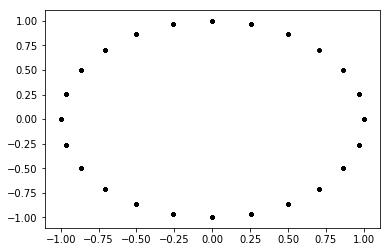

In [101]:
data = {'apples': 10, 'oranges': 15, 'lemons': 5, 'limes': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)

In [109]:
data_201709

,VISITOR_ID,CONNECTED_SESSION,ID_SESSION,SESSION_START_DATE,EVENT_DATE,PAGES,GLOBAL_SOURCES,DEVICE_TYPE,DEVICE_MODEL,LOADINGS
0,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:00:12,accueil,Email marketing,Ordinateur,NaN,1
1,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:07:23,accueil,Email marketing,Ordinateur,NaN,1
2,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:16:51,accueil,Email marketing,Ordinateur,NaN,1
3,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:19:24,accueil,Email marketing,Ordinateur,NaN,1
4,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:21:12,accueil,Email marketing,Ordinateur,NaN,1
5,433347,OUI,3,2017-09-01 00:00:12,2017-09-01 00:24:19,accueil,Email marketing,Ordinateur,NaN,1
6,628575,OUI,17,2017-09-01 00:01:16,2017-09-01 00:28:05,accueil,Accès Direct,Ordinateur,NaN,1
7,628575,OUI,17,2017-09-01 00:01:16,2017-09-01 00:46:21,accueil,Accès Direct,Ordinateur,NaN,1
8,0,NON,19,2017-09-01 00:01:16,2017-09-01 00:01:16,accueil,Liens Sponsorisés,Ordinateur,NaN,1
9,0,NON,19,2017-09-01 00:01:16,2017-09-01 00:02:30,accueil,Liens Sponsorisés,Ordinateur,NaN,1


In [110]:
CMD

,Unnamed: 0,CLIENT_NUMBER,ORDER_NUMBER,ORDER_DATE,ORDER_CHANNEL,PRE_TAX_AMOUNT,CVIC
0,0,7178742953965764755,2302390,2010-01-05,Telephone,84.28,True
1,1,-2373390172893352743,2302392,2010-01-17,Telephone,97.85,True
2,2,-240944575938990062,2302393,2010-01-05,Telephone,58.45,True
3,3,1720395480962300217,2302394,2010-01-05,Telephone,31.19,True
4,4,7161131950067982732,2302396,2010-01-14,Telephone,37.45,True
5,5,-792970086774522568,2302397,2010-01-20,Courier,53.59,True
6,6,-6274234340433084502,2302398,2010-01-05,Telephone,69.74,False
7,7,879133938684538799,2302399,2010-01-05,Telephone,95.64,False
8,8,3966491398253851080,2302400,2010-01-05,Telephone,59.78,True
9,9,-472287389046230983,2302401,2010-01-18,Courier,130.45,True


In [111]:
conver

,VISITOR_ID,CLIENT_NUMBER
0,153926,2117916268519517296
1,153987,-3983308646720649306
2,153992,-2525192206264180159
3,153996,1543724696132514059
4,154002,-3753347333864614269
5,154003,-6763383487168091997
6,154004,-7429564109483778435
7,154005,403207568119538010
8,154006,2387852670736446380
9,154007,8520924456824065788
